## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

## Get the dataset

In [2]:
data_f = pd.read_csv('./../data/clean_datav4.csv')

In [3]:
data_f['year']=pd.DatetimeIndex(data_f['date']).year
data_f['month']=pd.DatetimeIndex(data_f['date']).month
data_f['day']=pd.DatetimeIndex(data_f['date']).day

## Calculate average value of cci based on the surrounding regions

In [4]:
unique_group_ids = data_f['group_ids'].unique()
for group_id in unique_group_ids:
    temp_df = data_f[data_f['group_ids'].isin([group_id])]
    val = temp_df['cci'].mean()
    index_list = temp_df.index.values.tolist()
    data_f.loc[index_list, 'average'] = val

## Define the features

In [5]:
features = ['mean_temp','total_prep','latitudes','longitudes','event','year','month','day','average']

features_df = data_f[features].copy(deep=True)

test_feature = 'cci' ## We want to predict the cci
labels = data_f[test_feature].copy(deep=True) 

In [6]:
# One-hot encode the data using pandas get_dummies
weekday = pd.get_dummies(data_f['weekday'])

all_features_df = pd.concat([weekday, data_f[features].copy(deep=True)], axis=1, ignore_index=False)

In [7]:
# Saving feature names for later use
feature_list = list(all_features_df.columns)
features = np.array(features)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(all_features_df, labels, test_size = 0.25, random_state = 42)

In [9]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (43681, 16)
Training Labels Shape: (43681,)
Testing Features Shape: (14561, 16)
Testing Labels Shape: (14561,)


In [10]:
# The baseline predictions are the historical averages
baseline_preds = np.array(test_features['average'])
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  0.57


In [11]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [12]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.45


In [13]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 87.44 %.


### Visualizing feature importances

In [14]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: longitudes           Importance: 0.29
Variable: latitudes            Importance: 0.28
Variable: month                Importance: 0.11
Variable: average              Importance: 0.08
Variable: mean_temp            Importance: 0.07
Variable: day                  Importance: 0.07
Variable: total_prep           Importance: 0.05
Variable:                    0 Importance: 0.01
Variable:                    1 Importance: 0.01
Variable:                    2 Importance: 0.01
Variable:                    3 Importance: 0.01
Variable:                    4 Importance: 0.01
Variable:                    5 Importance: 0.01
Variable:                    6 Importance: 0.01
Variable: event                Importance: 0.01
Variable: year                 Importance: 0.0


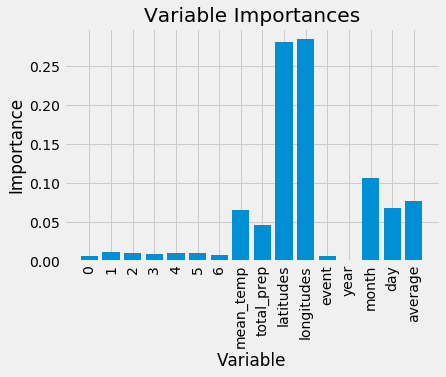

In [15]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [28]:
# Use datetime for creating date objects for plotting
import datetime
# Dates of training values
months = np.array(data_f['month'])
days = np.array(data_f['day'])
years = np.array(data_f['year'])

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})
true_data = true_data.sort_values(by='date')

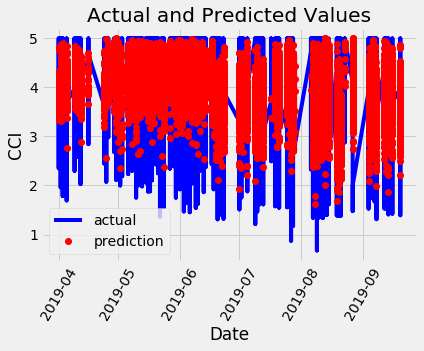

In [31]:
# Dates of predictions
months = np.array(test_features['month'])
days = np.array(test_features['day'])
years = np.array(test_features['year'])

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
predictions_data = predictions_data.sort_values(by='date')

# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('CCI'); plt.title('Actual and Predicted Values');

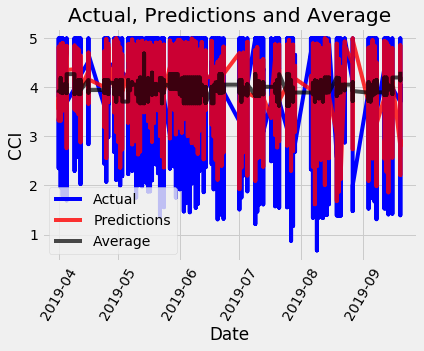

In [41]:
# Make the data accessible for plotting
true_data['average'] = np.array(data_f['average'])
true_data['friend'] = np.array(data_f['average'])
# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'Actual', alpha = 1.0)
plt.plot(predictions_data['date'], predictions_data['prediction'], 'r-', label = 'Predictions', alpha = 0.8)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'Average', alpha = 0.7)
# Formatting plot
plt.legend(); plt.xticks(rotation = '60');
# Lables and title
plt.xlabel('Date'); plt.ylabel('CCI'); plt.title('Actual, Predictions and Average');

## Export model

In [33]:
import pickle
# save the model to disk
filename = 'finalized_model.sav'
pickle.dump(rf, open(filename, 'wb'))